## Imports 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

In [2]:
def view_classify(img, ps):
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

## Loading the Data


In [3]:
# Define a transform to normalize the data (Preprocessing)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

## Creating the Model (Convolutional-Neural-Network)


In [4]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.fc1 = nn.Linear(1568, 128) # 32 * 7 * 7, 128
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [5]:
model = ConvNet()
print(model)

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


## Training

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

train_losses=[]
test_losses=[]
acc_list = []

epochs=15


for epoch in range(epochs):
    train_batch_loss = []
    for images, labels in iter(trainloader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_batch_loss.append(loss.item())
    
    mean_train_batch_loss = sum(train_batch_loss)/len(train_batch_loss)
    train_losses.append(mean_train_batch_loss)

    model.eval()
    with torch.no_grad():
        batch_test_loss=[]
        for t_images, t_labels in iter(testloader):
            t_images, t_labels= t_images.to(device), t_labels.to(device)
            logprob = model(t_images)
            probability = torch.exp(logprob)
            pred = probability.argmax(dim=1)
            test_loss = criterion(logprob, t_labels)
            acc = (pred == t_labels).sum() / len(t_labels) * 100
            acc_list.append(acc)
        model.train()
    print(f'Epoch: {epoch+1}/{epochs} | Acccuracy: {sum(acc_list)/len(acc_list)} | Train-Loss: {train_losses[epoch]} | Done!')

Epoch: 1/15 | Acccuracy: 99.12420654296875 | Train-Loss: 0.007357887271892499 | Done!
Epoch: 2/15 | Acccuracy: 99.14411163330078 | Train-Loss: 0.005765529488666435 | Done!
Epoch: 3/15 | Acccuracy: 99.14079284667969 | Train-Loss: 0.006727326914787453 | Done!
Epoch: 4/15 | Acccuracy: 99.1067886352539 | Train-Loss: 0.005789580898136207 | Done!
Epoch: 5/15 | Acccuracy: 99.10430145263672 | Train-Loss: 0.00467730920373838 | Done!
Epoch: 6/15 | Acccuracy: 99.06117248535156 | Train-Loss: 0.006122260346472816 | Done!
Epoch: 7/15 | Acccuracy: 99.08013153076172 | Train-Loss: 0.00698527865088757 | Done!
Epoch: 8/15 | Acccuracy: 99.09558868408203 | Train-Loss: 0.0015962307352198766 | Done!
Epoch: 9/15 | Acccuracy: 99.09877014160156 | Train-Loss: 0.006670593353980034 | Done!
Epoch: 10/15 | Acccuracy: 99.10629272460938 | Train-Loss: 0.003550663592762725 | Done!
Epoch: 11/15 | Acccuracy: 99.11605834960938 | Train-Loss: 0.005900729296947834 | Done!
Epoch: 12/15 | Acccuracy: 99.1308364868164 | Train-Los

In [27]:
torch.save(model, 'trained_model_15b.pth')


## Prediction


In [28]:
net = ConvNet()
net = torch.load('trained_model_15b.pth')
net.eval()

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)

The given Image is classified as: 9


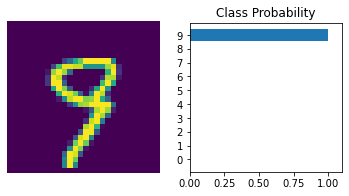

In [40]:
images, labels = next(iter(testloader))
images=images.to(device)
labels=labels.to(device)
logits = net.forward(images[1].view(1,1,28,28))
ps = F.softmax(logits, dim=1)
view_classify(images[1].view(1, 28, 28), ps)
print(f'The given Image was classified as: {torch.argmax(ps)}')